In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax
import gymnax
from gymnax.wrappers.purerl import LogWrapper, FlattenObservationWrapper
import time

import sys
sys.path.insert(0, '..')  # adds the root directory to the path

# from policy_distillation.behaviour_clone import BCAgent, Transition, make_train
import matplotlib.pyplot as plt

# Meta-learning the Dataset

## Definitions

In [2]:
class BCAgentContinuous(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"
    width: int = 64 #256 for Brax

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            self.width, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.width, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        actor_logtstd = self.param("log_std", nn.initializers.zeros, (self.action_dim,))
        pi = distrax.MultivariateNormalDiag(actor_mean, jnp.exp(actor_logtstd))

        return pi

class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray

In [3]:
def make_train(config):
    """Create training function based on config."""
    config["NUM_UPDATES"] = config["UPDATE_EPOCHS"]

    env, env_params = gymnax.make(config["ENV_NAME"])
    env_params = env_params.replace(**config["ENV_PARAMS"])
    env = FlattenObservationWrapper(env)
    env = LogWrapper(env)

    # Do I need a schedule on the LR for BC?
    def linear_schedule(count):
        frac = 1.0 - (count // config["NUM_UPDATES"])
        return config["LR"] * frac

    def train(synth_data, action_labels, rng):
        """Train using BC on synthetic data with fixed action labels and evaluate on RL environment"""
        
        if "Continuous" in config["ENV_NAME"] or "Brax" in config["ENV_NAME"]:
            action_shape = env.action_space().shape[0]
            is_continuous = True
        else:
            action_shape = env.action_space().n
            is_continuous = False
        network = BCAgentContinuous(
            action_shape, activation=config["ACTIVATION"], width=config["WIDTH"]
        )

        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space(env_params).shape)
        network_params = network.init(_rng, init_x)

        assert (
                synth_data[0].shape == env.observation_space(env_params).shape
        ), f"Data of shape {synth_data[0].shape} does not match env observations of shape {env.observation_space(env_params).shape}"

        # Setup optimizer
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(config["LR"], eps=1e-5),
            )

        # Train state carries everything needed for NN training
        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )

        # 2. BC TRAIN LOOP
        def _bc_train(train_state, rng):
            def _bc_update_step(bc_state, unused):
                train_state, rng = bc_state

                def _loss_and_acc(params, apply_fn, step_data, y_true, num_classes, grad_rng):
                    """Compute cross-entropy loss and accuracy."""
                    pi = apply_fn(params, step_data)
                    y_pred = pi.sample(seed=grad_rng)
                    
                    acc = jnp.mean(jnp.abs(y_pred - y_true))
                    log_prob = -pi.log_prob(y_true)
                    loss = jnp.sum(log_prob)
#                     loss = jnp.sum(jnp.abs(y_pred - y_true))
                    loss /= y_true.shape[0]
                    
                    return loss, acc

                grad_fn = jax.value_and_grad(_loss_and_acc, has_aux=True)

                # Not needed if using entire dataset
                rng, perm_rng = jax.random.split(rng)
                perm = jax.random.permutation(perm_rng, len(action_labels))
                step_data = synth_data[perm]
                y_true = action_labels[perm]
                
                rng, grad_rng = jax.random.split(rng)

                loss_and_acc, grads = grad_fn(
                    train_state.params,
                    train_state.apply_fn,
                    step_data,
                    y_true,
                    action_shape,
                    grad_rng
                )
                train_state = train_state.apply_gradients(grads=grads)
                bc_state = (train_state, rng)
                return bc_state, loss_and_acc

            bc_state = (train_state, rng)
            bc_state, loss_and_acc = jax.lax.scan(
                _bc_update_step, bc_state, None, config["UPDATE_EPOCHS"]
            )
            loss, acc = loss_and_acc
            return bc_state, loss, acc

        rng, _rng = jax.random.split(rng)
        bc_state, bc_loss, bc_acc = _bc_train(train_state, _rng)
        train_state = bc_state[0]

        # Init envs
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = jax.vmap(env.reset, in_axes=(0, None))(reset_rng, env_params)

        # 3. POLICY EVAL LOOP
        def _eval_ep(runner_state):
            # Environment stepper
            def _env_step(runner_state, unused):
                train_state, env_state, last_obs, rng = runner_state

                # Select Action
                rng, _rng = jax.random.split(rng)
                pi = train_state.apply_fn(train_state.params, last_obs)
                if config["GREEDY_ACT"]:
                    action = pi.argmax(
                        axis=-1
                    )  # if 2+ actions are equiprobable, returns first
                else:
                    action = pi.sample(seed=_rng)

                # Step env
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])

                obsv, env_state, reward, done, info = jax.vmap(
                    env.step, in_axes=(0, 0, 0, None)
                )(rng_step, env_state, action, env_params)
                transition = Transition(
                    done, action, -1, reward, pi.log_prob(action), last_obs, info
                )
                runner_state = (train_state, env_state, obsv, rng)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )
            metric = traj_batch.info
            return runner_state, metric

        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, obsv, _rng)
        runner_state, metric = _eval_ep(runner_state)

        metric["bc_loss"] = bc_loss
        metric["bc_accuracy"] = bc_acc
        
        metric["states"] = synth_data
        metric["action_labels"] = action_labels
        metric["rng"] = rng

        return {"runner_state": runner_state, "metrics": metric}

    return train



## Setup

In [29]:
from evosax import OpenES, ParameterReshaper

env_name = "MountainCarContinuous-v0"
env, env_params = gymnax.make(env_name)
env = FlattenObservationWrapper(env)
env = LogWrapper(env)

# n_actions = env.action_space(env_params).n
action_shape = env.action_space(env_params).shape

config = {
    "LR": 2.5e-2,  # 5e-3      # 2.5e-2 to 5e-2 brings BC loss to ~0 for UPDATE_EPOCHS=10 and up to 100 states/action
    "NUM_ENVS": 16,   #8 # Num eval envs
    "NUM_STEPS": 1024,   #128 # Max num eval steps per env
    "UPDATE_EPOCHS": 400,  # Num BC gradient steps
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu",
    "WIDTH" : 64,
    "ENV_NAME": env_name,
    "ANNEAL_LR": True,
    "GREEDY_ACT": False,  # Whether to use greedy act in env or sample
    "ENV_PARAMS" : {}
}

es_config = {
    "popsize": 500,  # Num of candidates
    "dataset_size": 8, #10 #20000,  # Num of (s,a) pairs (split evenly across actions)
    "rollouts_per_candidate": 16,  #32 Num of BC policies trained per candidate
    "n_generations": 20,
    "log_interval": 1,
}

params = {
    "states" : jnp.zeros((es_config["dataset_size"], *env.observation_space(env_params).shape)),
    "actions": jnp.zeros((es_config["dataset_size"], *env.action_space(env_params).shape))
}
param_reshaper = ParameterReshaper(params)

rng = jax.random.PRNGKey(0)

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 24 parameters detected for optimization.


## Initialize Strategy

In [30]:
# Initialize OpenES Strategy
# rng = jax.random.PRNGKey(0)
rng, rng_init = jax.random.split(rng)

strategy = OpenES(
    popsize=es_config["popsize"],
    num_dims=param_reshaper.total_params,
    opt_name="adam",
    maximize=True,
)

# Replace state mean with real observations
# state = state.replace(mean = sampled_data)

es_params = strategy.default_params
# es_params = es_params.replace(init_max=1.0)
state = strategy.initialize(rng_init, es_params)

# Set up vectorized fitness function
train_fn = make_train(config)

def single_seed_BC(rng_input, dataset, action_labels):
    out = train_fn(dataset, action_labels, rng_input)
    return out  # ["metrics"]['returned_episode_returns'].mean()


multi_seed_BC = jax.vmap(single_seed_BC, in_axes=(0, None, None))  # Vectorize over seeds
train_and_eval = jax.jit(jax.vmap(multi_seed_BC, in_axes=(None, 0, 0)))  # Vectorize over datasets (states) and actions

if len(jax.devices()) > 1:
    train_and_eval = jax.pmap(train_and_eval, in_axes=(None, 0, 0))

## Run OpenES loop

In [31]:
start = time.time()
lap_start = start
fitness_over_gen = []
max_fitness_over_gen = []
for gen in range(es_config["n_generations"]):
    # Gen new dataset
    rng, rng_ask, rng_inner = jax.random.split(rng, 3)
    datasets, state = jax.jit(strategy.ask)(rng_ask, state, es_params)
    # Eval fitness
    batch_rng = jax.random.split(rng_inner, es_config["rollouts_per_candidate"])
    # Preemptively overwrite to reduce memory load
    out = None
    returns = None
    dones = None
    fitness = None
    shaped_datasets = None

    with jax.disable_jit(False):
        shaped_datasets = param_reshaper.reshape(datasets) 
        
        out = train_and_eval(batch_rng, shaped_datasets["states"], shaped_datasets["actions"])

        returns = out["metrics"]["returned_episode_returns"]  # dim=(popsize, rollouts, num_steps, num_envs)
        dones = out["metrics"]["returned_episode"]  # same dim, True for last steps, False otherwise
        
        # Division by zero, watchout
        fitness = (returns * dones).sum(axis=(-1, -2, -3)) / dones.sum(axis=(-1, -2, -3))  # fitness, dim = (popsize)
        fitness = fitness.flatten()    # Necessary if pmap-ing to 2+ devices
#         fitness = jnp.minimum(fitness, fitness.mean()+40)


    # Update ES strategy with fitness info
    state = jax.jit(strategy.tell)(datasets, fitness, state, es_params)
    fitness_over_gen.append(fitness.mean())
    max_fitness_over_gen.append(fitness.max())

    if gen % es_config["log_interval"] == 0 or gen == 0:
        lap_end = time.time()
        if len(jax.devices()) > 1:
            bc_loss = out["metrics"]["bc_loss"][:,:,:,-1]
            bc_acc = out["metrics"]["bc_accuracy"][:,:,:,-1]
        else:
            bc_loss = out["metrics"]["bc_loss"][:,:,-1]
            bc_acc = out["metrics"]["bc_accuracy"][:,:,-1]
        
        print(
            f"Gen: {gen}, Fitness: {fitness.mean():.2f} +/- {fitness.std():.2f}, "
            + f"Best: {state.best_fitness:.2f}, BC loss: {bc_loss.mean():.2f} +/- {bc_loss.std():.2f}, "
            + f"BC mean error: {bc_acc.mean():.2f} +/- {bc_acc.std():.2f}, Lap time: {lap_end-lap_start:.1f}s"
        )
        lap_start = lap_end
print(f"Total time: {(lap_end-start)/60:.1f}min")


Gen: 0, Fitness: -110.58 +/- 422.16, Best: 14.39, BC loss: -2.98 +/- 0.37, BC mean error: 0.02 +/- 0.01, Lap time: 5.8s
Gen: 1, Fitness: -217.86 +/- 612.15, Best: 75.34, BC loss: -2.72 +/- 0.42, BC mean error: 0.02 +/- 0.01, Lap time: 2.7s
Gen: 2, Fitness: -58.98 +/- 267.55, Best: 75.34, BC loss: -2.94 +/- 0.38, BC mean error: 0.02 +/- 0.01, Lap time: 2.7s
Gen: 3, Fitness: -21.71 +/- 271.41, Best: 75.34, BC loss: -3.11 +/- 0.30, BC mean error: 0.02 +/- 0.01, Lap time: 2.6s
Gen: 4, Fitness: -3.89 +/- 13.31, Best: 75.34, BC loss: -3.18 +/- 0.26, BC mean error: 0.01 +/- 0.00, Lap time: 2.6s
Gen: 5, Fitness: -4.67 +/- 13.55, Best: 75.34, BC loss: -3.14 +/- 0.27, BC mean error: 0.01 +/- 0.00, Lap time: 2.6s
Gen: 6, Fitness: -5.87 +/- 25.25, Best: 75.34, BC loss: -3.12 +/- 0.27, BC mean error: 0.01 +/- 0.01, Lap time: 2.6s
Gen: 7, Fitness: -3.51 +/- 7.60, Best: 75.34, BC loss: -3.11 +/- 0.28, BC mean error: 0.01 +/- 0.01, Lap time: 2.6s
Gen: 8, Fitness: -3.31 +/- 6.66, Best: 75.34, BC loss: 

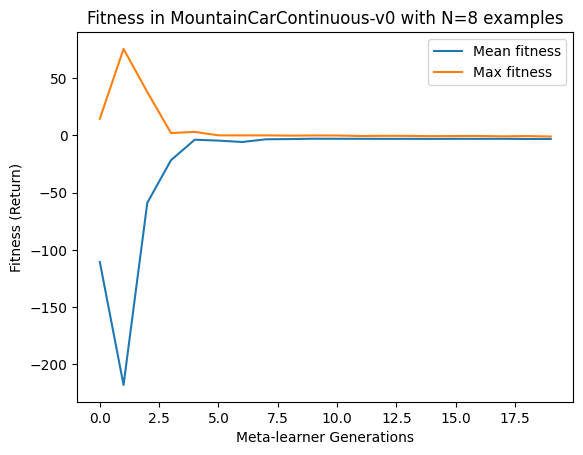

In [35]:
from scipy.signal import savgol_filter
# savgol_filter(y, 20, 3)

y = fitness_over_gen
plt.plot(fitness_over_gen, label="Mean fitness")
y = max_fitness_over_gen
plt.plot(max_fitness_over_gen, label="Max fitness")
plt.title(f"Fitness in {config['ENV_NAME']} with N={es_config['dataset_size']} examples")
plt.ylabel("Fitness (Return)")
plt.xlabel("Meta-learner Generations")
plt.legend()
plt.show()

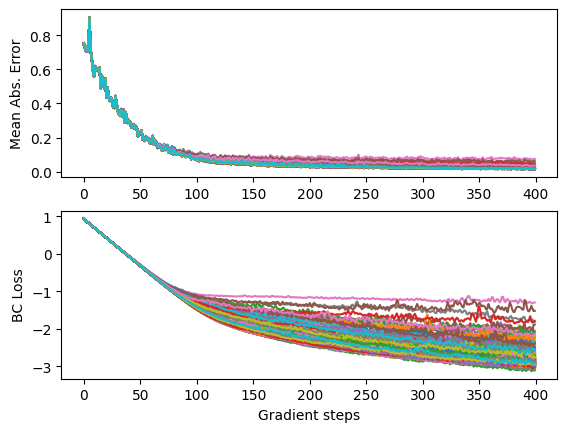

In [33]:
def reshape(arr):
    """Removes extra dim due to pmap"""
    dims = arr.shape
    arr = arr.reshape(-1,dims[-2],dims[-1])
    return arr

fig, ax = plt.subplots(2, 1)
for i in range(es_config["popsize"]):
    acc = reshape(out["metrics"]["bc_accuracy"])[i].mean(axis=0)
    ax[0].plot(acc)
    ax[0].set_ylabel("Mean Abs. Error")

    loss = reshape(out["metrics"]["bc_loss"])[i].mean(axis=0)
    ax[1].plot(loss)
    ax[1].set_ylabel("BC Loss")
    ax[1].set_xlabel("Gradient steps")

## Double check policy return

### Best candidate

In [17]:
x = jnp.expand_dims(state.best_member, axis=0)
x.shape

x = jnp.zeros((2,*state.best_member.shape))
x = x.at[0].set(state.best_member)

y = param_reshaper.reshape(x)
print(y["actions"][0])
print(y["states"][0])

[[[ 0.02647082]
  [-0.10759805]
  [-0.09082104]
  [-0.04505327]
  [-0.07241086]
  [ 0.00059466]
  [ 0.04630487]
  [ 0.07953803]]]
[[[-0.02989275  0.06484537]
  [-0.07938507 -0.03848409]
  [-0.04461086 -0.04489848]
  [-0.04499573 -0.04158749]
  [-0.05004729 -0.02404632]
  [ 0.00213029  0.058394  ]
  [-0.12081257 -0.02560322]
  [-0.06771043 -0.02748272]]]


### Best of last gen

In [18]:
P = es_config["popsize"]
final_datasets_reshaped = param_reshaper.reshape(datasets)

best = fitness.argmax()

if len(jax.devices()) > 1:
    best_idx = (best // (P//2), best % (P//2))
else:
    best_idx = (best % (P//2))
    
if len(jax.devices()) > 1:
    f = lambda x : x[best_idx[0], best_idx[1]]
else:
    f = lambda x : x[best_idx]
final_dataset = jax.tree_util.tree_map(f, final_datasets_reshaped)

print("Final dataset:")
print(final_dataset)

Final dataset:
{'actions': Array([[ 0.02647082],
       [-0.10759805],
       [-0.09082104],
       [-0.04505327],
       [-0.07241086],
       [ 0.00059466],
       [ 0.04630487],
       [ 0.07953803]], dtype=float32), 'states': Array([[-0.02989275,  0.06484537],
       [-0.07938507, -0.03848409],
       [-0.04461086, -0.04489848],
       [-0.04499573, -0.04158749],
       [-0.05004729, -0.02404632],
       [ 0.00213029,  0.058394  ],
       [-0.12081257, -0.02560322],
       [-0.06771043, -0.02748272]], dtype=float32)}


In [28]:
train_state = out["runner_state"][0]
# Note: if multiple rollouts / candidate, pick first rollout
if len(jax.devices()) > 1:
    f = lambda x : x[best_idx[0], best_idx[1], 0]
else:
    f = lambda x : x[best_idx, 0]
best_params = jax.tree_util.tree_map(f, train_state.params)

best_ret = returns[best_idx]
best_dones = dones[best_idx]

best_mean_ret  = (best_ret * best_dones).sum(axis=(-1, -2)) /best_dones.sum(axis=(-1, -2))
print("Best mean return per rollout \n", best_mean_ret)

ValueError: axis -2 is out of bounds for array of dimension 1

In [ ]:
env, env_params = gymnax.make(config["ENV_NAME"])
env = FlattenObservationWrapper(env)
env = LogWrapper(env)

n_actions = env.action_space(env_params).n

rng = jax.random.PRNGKey(42)
rng, reset_rng = jax.random.split(rng)
obs, env_state = env.reset(reset_rng, env_params)

rewards_per_ep = []

for t in tqdm(range(512)):
    rng, rng_act, rng_step = jax.random.split(rng, 3)
    
    pi = train_state.apply_fn(best_params, obs)
    action = pi.argmax(axis=-1)
    
    obs, env_state, reward, done, info = env.step(rng_step, env_state, action, env_params) 
    rewards_per_ep.append(reward)
    if done:
        ep_ret = jnp.array(rewards_per_ep).sum()
        print("Ep return: ", ep_ret)
        rewards_per_ep = []


In [ ]:
from policy_distillation.render import render_mountaincar as render_fn

fig, ax = plt.subplots(1,n_actions, figsize=(12,8))

for i, synth_state in enumerate(final_dataset):
    img = render_fn(synth_state, env_params)
    ax[i].imshow(img, label="hello")
    ax[i].set_title(f"action = {action_labels[i]}")
    
    v = synth_state[-1].item()
    
    
    print(synth_state)
    
#     ax[i].set_xticks([0, 600/2, 600], [-4.8, 0, 4.8])
    ax[i].text(30, 70, f"v={v:.2f}", bbox=dict(fill=False, edgecolor='red', linewidth=2))

## TODO:

1. Investigate nan / fitness computation for CartPole
    - Division by zero if episodes not done


## Generalization

In [20]:
width_list = [2,4,8,16,32,64,128,256,512,1024]
fit_list = {
            "relu" : [],
            "tanh" : []
           }
for width in width_list:
    new_config = config.copy()
    new_config["WIDTH"] = width
    new_config["UPDATE_EPOCHS"] = config["UPDATE_EPOCHS"]
    num_envs = 20
    
    fitness ={
            "relu" : -1,
            "tanh" : -1
           }
    
    for activation in ["relu", "tanh"]:
        new_config["ACTIVATION"] = activation

#         final_dataset # Given
#         action_labels # Given

        new_train_fn = make_train(new_config)

        def new_BC_train(rng_input, dataset, action_labels):
            out = new_train_fn(dataset, action_labels, rng_input)
            return out  # ["metrics"]['returned_episode_returns'].mean()

        vmapped_BC_train = jax.jit(jax.vmap(new_BC_train, in_axes=(0, None, None)))

        rng, rng_new = jax.random.split(rng)
        rng_batch = jax.random.split(rng_new, num_envs)

        out_new = vmapped_BC_train(rng_batch, final_dataset["states"], final_dataset["actions"])

        returns = out_new["metrics"]["returned_episode_returns"]  # dim=(popsize, rollout_news, num_steps, num_envs)
        dones = out_new["metrics"]["returned_episode"]  # same dim, True for last steps, False otherwise
        fitness[activation] = (returns * dones).sum(axis=(-1,-2)) / dones.sum(axis=(-1,-2))  # fitness, dim = (popsize)

        bc_loss = out_new['metrics']['bc_loss'][:,-1]

        fit_list[activation].append(fitness[activation])
    
    print(f"Width {width} : fitness (relu)={fitness['relu'].mean():.1f} +/- {fitness['relu'].std():.1f}, "
         + f"fitness (tanh)={fitness['tanh'].mean():.1f} +/- {fitness['tanh'].std():.1f}")
    

Width 2 : fitness (relu)=-9.6 +/- 25.7, fitness (tanh)=-1.9 +/- 5.9
Width 4 : fitness (relu)=-113.1 +/- 550.2, fitness (tanh)=-2.1 +/- 5.8
Width 8 : fitness (relu)=-12.0 +/- 147.3, fitness (tanh)=-2.1 +/- 2.0
Width 16 : fitness (relu)=14.3 +/- 101.7, fitness (tanh)=-3.4 +/- 1.8
Width 32 : fitness (relu)=4.9 +/- 152.7, fitness (tanh)=-3.3 +/- 2.2
Width 64 : fitness (relu)=72.7 +/- 27.6, fitness (tanh)=-3.6 +/- 1.7
Width 128 : fitness (relu)=51.9 +/- 46.3, fitness (tanh)=-4.0 +/- 4.5
Width 256 : fitness (relu)=46.5 +/- 45.4, fitness (tanh)=-2.3 +/- 1.6
Width 512 : fitness (relu)=-7.4 +/- 108.3, fitness (tanh)=-11.4 +/- 16.9
Width 1024 : fitness (relu)=5.3 +/- 71.2, fitness (tanh)=-35.7 +/- 46.9


In [ ]:
# width_list = [2,4,8,16,32,64,128,256,512,1024]
# fit_list = {
#             "relu" : [],
#             "tanh" : []
#            }
# for width in width_list:
#     new_config = config.copy()
#     new_config["WIDTH"] = width
#     new_config["UPDATE_EPOCHS"] = 20
#     num_envs = 20
    
#     fitness ={
#             "relu" : -1,
#             "tanh" : -1
#            }
    
#     for activation in ["relu", "tanh"]:
#         new_config["ACTIVATION"] = activation

#         final_dataset # Given
#         action_labels # Given

#         new_train_fn = make_train(new_config)

#         def new_BC_train(rng_input, dataset):
#             out = new_train_fn(dataset, action_labels, rng_input)
#             return out  # ["metrics"]['returned_episode_returns'].mean()

#         vmapped_BC_train = jax.jit(jax.vmap(new_BC_train, in_axes=(0, None)))

#         rng, rng_new = jax.random.split(rng)
#         rng_batch = jax.random.split(rng_new, num_envs)

#         out_new = vmapped_BC_train(rng_batch, final_dataset)

#         returns = out_new["metrics"]["returned_episode_returns"]  # dim=(popsize, rollout_news, num_steps, num_envs)
#         dones = out_new["metrics"]["returned_episode"]  # same dim, True for last steps, False otherwise
#         fitness[activation] = (returns * dones).sum(axis=(-1,-2)) / dones.sum(axis=(-1,-2))  # fitness, dim = (popsize)

#         bc_loss = out_new['metrics']['bc_loss'][:,-1]

#         fit_list[activation].append(fitness[activation])
    
#     print(f"Width {width} : fitness (relu)={fitness['relu'].mean():.1f} +/- {fitness['relu'].std():.1f}, "
#          + f"fitness (tanh)={fitness['tanh'].mean():.1f} +/- {fitness['tanh'].std():.1f}")
    

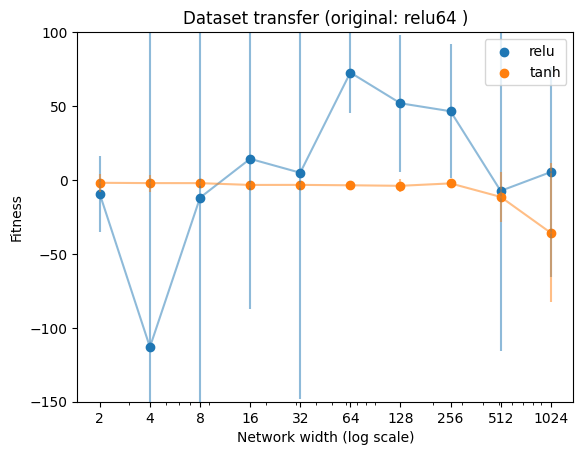

In [23]:
for activation, act_fit_list in fit_list.items():
    plt.scatter(width_list, [x.mean() for x in act_fit_list], label=activation)

    means = jnp.array([x.mean() for x in act_fit_list])
    stds = jnp.array([x.std() for x in act_fit_list])

    plt.errorbar(width_list, means, stds, alpha=0.5)
plt.ylabel("Fitness")
plt.xlabel("Network width (log scale)")
plt.xscale("log")
plt.xticks(width_list, width_list)
plt.title(f"Dataset transfer (original: {config['ACTIVATION']}{config['WIDTH']} )")
plt.ylim(-150, 100)
plt.legend()
plt.show()